In [2]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

In [3]:
loc_df = r"C:\Users\FacundoTorraca\Documents\Facultad\Organizacion de Datos\Trabajo Practico 1\CSV"

In [4]:
dtypes_auc = { "auction_type_id": np.float16, "country": "category", "platform": "category", "ref_type_id": "category", 
               "source_id": "category" }

dtypes_clk = { "advertiser_id": np.int8, "action_id": np.float16, "source_id": np.int8, "country_code": "category", 
               "latitude": np.float16, "longitude": np.float16, "wifi_connection": "category", "carrier_id": np.float16,
               "trans_id": "object", "os_major":np.float32, "brand": np.float16, "touchX": np.float16,
               "touchY": np.float16  }

In [5]:
df_auc = pd.read_csv( loc_df + "\\auctions.csv.gzip", compression = "gzip", dtype = dtypes_auc, low_memory = False )

In [6]:
df_clk = pd.read_csv( loc_df + "\\clicks.csv.gzip", compression = "gzip" , dtype = dtypes_clk, low_memory = False )

In [ ]:
df_evt = pd.read_csv( loc_df + "\\events.csv.gzip", compression = "gzip", dtype = dtypes_evt, low_memory = False )

### Sobre el archivo auctions.csv queremos encontrar los 5 dispositivos que más participaron en subastas. Para esos 5 dispositivos, queremos visualizar la evolución en el tiempo de la cantidad de subastas.

In [8]:
df_auc["device_id"].value_counts().head( 5 )

633139769114048761     27762
7202276635029175071    23055
7298861376107043945    18188
6302840482782120473    16400
5376802567578262905    16367
Name: device_id, dtype: int64

In [9]:
df_auc["date"] =  pd.to_datetime( df_auc["date"], errors = "coerce" )
df_auc_device = df_auc.loc[ (df_auc["device_id"] == 633139769114048761) | (df_auc["device_id"] == 7202276635029175071) | (df_auc["device_id"] == 7298861376107043945) |
                            (df_auc["device_id"] == 6302840482782120473) | (df_auc["device_id"] == 5376802567578262905),  
                            ["date", "device_id"]  ].groupby( [ "device_id", df_auc["date"].dt.date] ).count()
df_auc_device.columns = ["auc_cumulation"]
df_auc_device.reset_index( inplace = True )
df_auc_device["auc_cumulation"] = df_auc_device["auc_cumulation"].cumsum()

In [10]:
df_auc_device["date"] =  pd.to_datetime( df_auc_device["date"], errors = "coerce" )
df_auc_device["day"] = df_auc_device["date"].dt.day

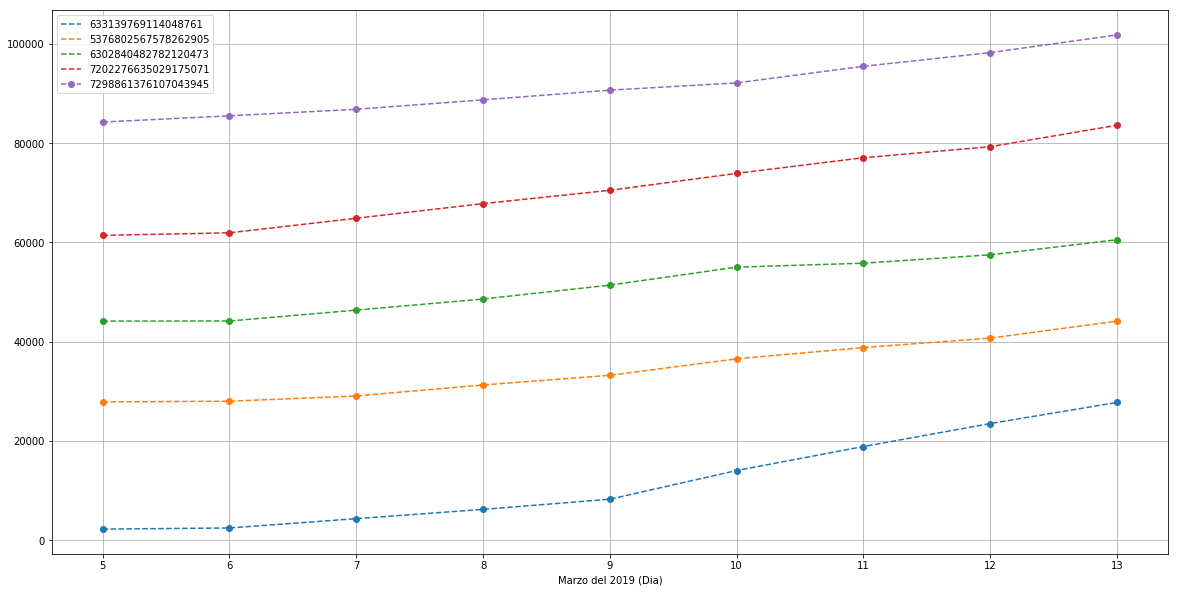

In [11]:
fig, ax = plt.subplots(figsize=(20,10))
for i, g in df_auc_device.groupby('device_id'):
    g.plot( x = 'day', y = 'auc_cumulation', ax=ax, label=str(i), grid = True, style = 'o--' )

ax.set(xlabel= "Marzo del 2019 (Dia)");

### Encontrar en qué horario (si es que lo hay) se suele registrar la mayor cantidad de clicks. Armar una visualización que muestre los resultados obtenidos

In [12]:
df_clk_time = df_clk["created"]
df_clk_time = df_clk_time.to_frame()
df_clk_time["created"] = pd.to_datetime( df_clk_time["created"], errors = "coerce" )

In [13]:
df_clk_time["time"] = df_clk_time["created"].dt.time

In [14]:
df_clk_time.sort_values( by = "time" )
df_clk_time["created"] = df_clk_time["created"].apply(lambda dt: dt.replace(day=1)) #Le cambio el dia ya que solo importa la hora

In [16]:
start = dt.datetime(2019, 3, 1, 0, 0, 0)
dt_array = np.array( [ (start + dt.timedelta(minutes = 30 * x) ) for x in range(0, 49) ])

In [17]:
df_time_range = pd.cut( df_clk_time["created"], dt_array, include_lowest=True )

In [18]:
df_time_range = df_time_range.to_frame()["created"].value_counts().to_frame().reset_index()

In [19]:
df_time_range.columns = ["time_range", "count"]

In [20]:
df_time_range= df_time_range.sort_values( by = "time_range")

In [21]:
start = dt.datetime(2019, 3, 1, 0, 0, 0)
start_def = dt.datetime(2019, 3, 1, 0, 30, 0)
array = [ (start + dt.timedelta(minutes = 30 * x) ).time() for x in range(0, 48) ] 
array_def = [ (start_def + dt.timedelta(minutes = 30 * x) ).time() for x in range(0, 48) ]
interval = list( zip( array, array_def ) )

In [22]:
df_time_range["time_range_ref"] = interval

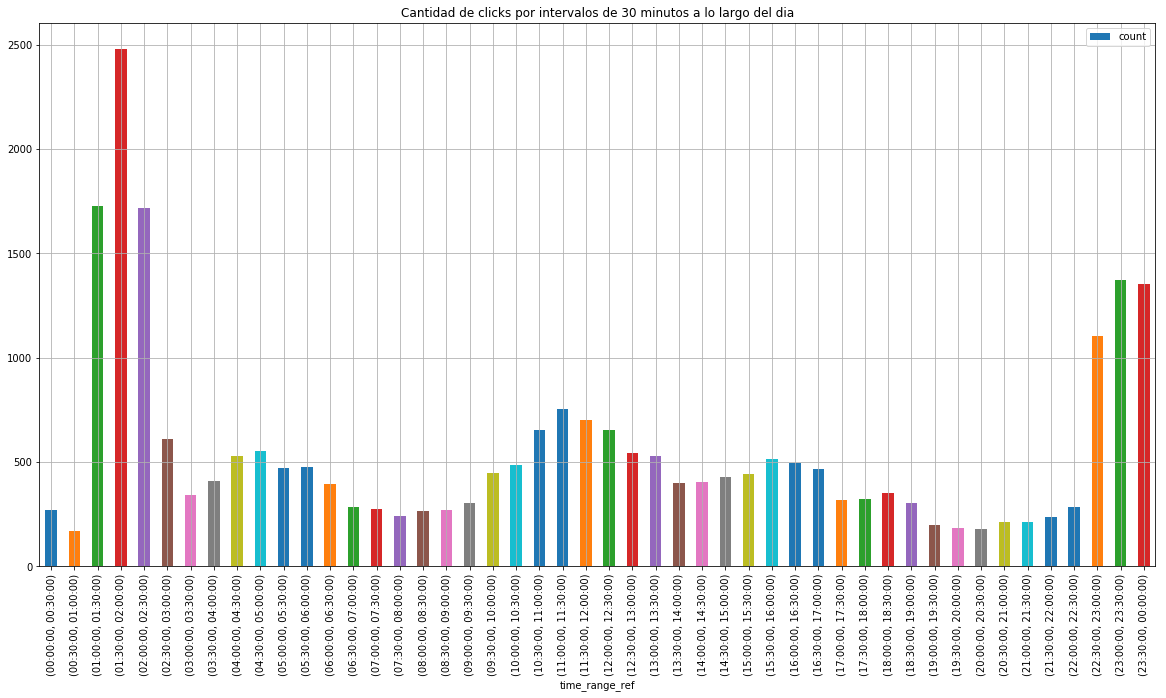

In [30]:
title = "Cantidad de clicks por intervalos de 30 minutos a lo largo del dia"
df_time_range.plot( kind = "bar", x = "time_range_ref", y = "count", figsize = [20,10], grid = True, title = title );

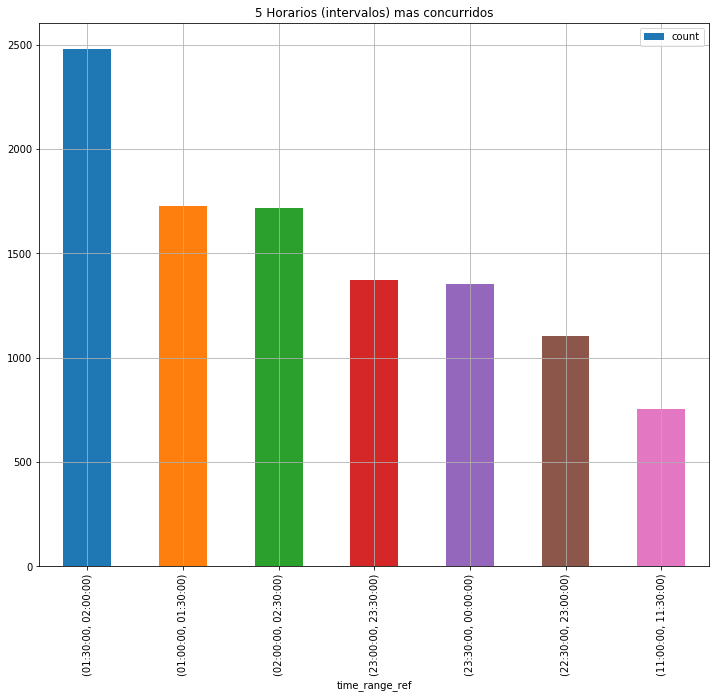

In [34]:
title = "5 Horarios (intervalos) mas concurridos"
df_time_range.nlargest( 7, columns = ["count"] ).plot( kind = "bar", x = "time_range_ref", y = "count", figsize = [12,10], grid = True, title = title );

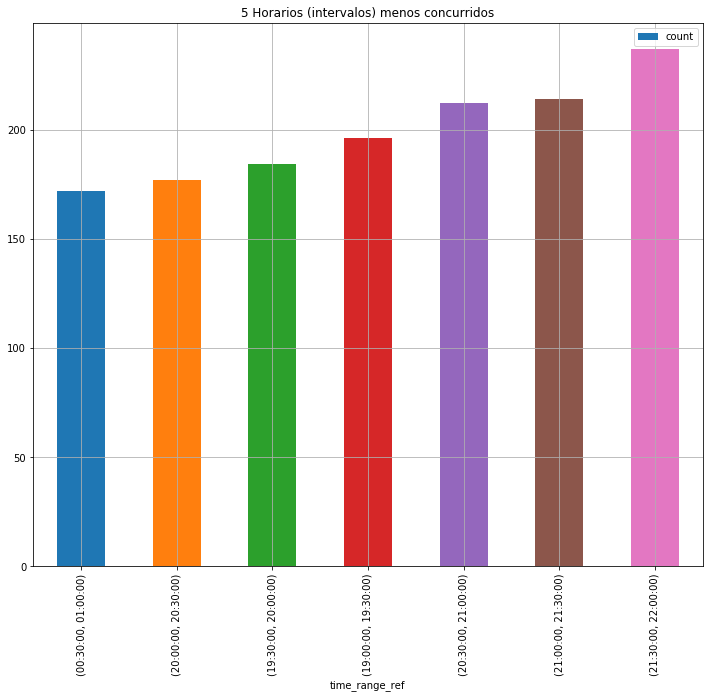

In [35]:
title = "5 Horarios (intervalos) menos concurridos"
df_time_range.nsmallest( 7, columns = ["count"] ).plot( kind = "bar", x = "time_range_ref", y = "count", figsize = [12,10], grid = True, title = title );